In [3]:
#import lib พื้นฐานที่จำเป็น
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore") # เอาไว้ ลบwarning 


In [4]:
#import dataset และ print เช็คข้อมูล
data = pd.read_csv("data.csv")
data.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            45000 non-null  int64 
 1   Title         45000 non-null  object
 2   Body          45000 non-null  object
 3   Tags          45000 non-null  object
 4   CreationDate  45000 non-null  object
 5   Y             45000 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.1+ MB


In [6]:
#ตัด feature ใน dataset ที่ไม่จำเป็นออกไป
data = data.drop(['Id' , 'Tags' , 'CreationDate'],axis=1) # ลบ feature ที่ไม่สำคัญออกไป
data['Y'] = data['Y'].map({'LQ_CLOSE':0,'LQ_EDIT':1,'HQ':2}) # encoded target class ใหม่ให้กลายเป็นตัวเลข ตามลำดับ

data.head()

,Title,Body,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,0
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,2
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,2
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",2
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,2


In [7]:
data['text'] = data['Title'] + ' ' + data['Body'] # รวม Title และ Body เข้าด้วยกันเพื่อเตรียมไปใส่ในmodel และเปลี่ยนชื่อเป็น text
data = data.drop(['Title','Body'],axis=1) # ทิ้งอันเดิม ออก
data.head()

,Y,text
0,0,Java: Repeat Task Every Random Seconds <p>I'm ...
1,2,Why are Java Optionals immutable? <p>I'd like ...
2,2,Text Overlay Image with Darkened Opacity React...
3,2,Why ternary operator in swift is so picky? <p>...
4,2,hide/show fab with scale animation <p>I'm usin...


In [8]:
import re # import regularexpression
def clean(text): # ฟังก์ชั่น ลบเครื่องหมายต่างๆ ที่ไม่ใช่text ออก เช่น? <> โดยใช้ regular expression
    text = text.lower() # เปลี่ยนให้เป็น lower case
    text = re.sub(r'[^(a-zA-Z)\s]','',text)
    return text

In [9]:
data['text'] = data['text'].apply(clean) # เรียกใช้ ฟังก์ชั่น clean

data.head()

,Y,text
0,0,java repeat task every random seconds pim alre...
1,2,why are java optionals immutable pid like to u...
2,2,text overlay image with darkened opacity react...
3,2,why ternary operator in swift is so picky pthe...
4,2,hideshow fab with scale animation pim using cu...


### สร้างvector ของข้อมูล โดยเลือกใช้ Word tokenized

In [10]:
X = data['text'].values # แยก feature กับ target class ออกจากกัน
y = data['Y'].values

In [12]:
def plot_history(model): # ฟังก์ชั่นสำหรับใช้ plot graph วัดประสิทธิภาพโมเดล
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### สร้างmodel แต่ใช้ word embeding และ flatern layers มาใส่ในmodel ด้วย

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding

tokenizer = Tokenizer(num_words=300)
tokenizer.fit_on_texts(X)
vocab = tokenizer.word_index


In [25]:
X_tokenized = tokenizer.texts_to_sequences(X)
#max_seq_length = max(len(seq) for seq in X_tokenized)
X_padded = pad_sequences(X_tokenized, maxlen=150, padding='post', truncating='post')

ในการทำ word embeding จะเลือกใช้วิธี wordTokenized โดยการตั้งให้จำนวน numword = 300 เพราะคำบางไม่ได้มีความสำคัญต่อการฝึกมากขนาดนั้น ถึงแม้จะมีจำนวนที่มากก็ตาม


ส่วนในการ padding จะเลือกใช้ แค่ 150 เพราะค่าอื่นๆมันมากเกินไปและไม่มีความจำเป็นต่อการ train 

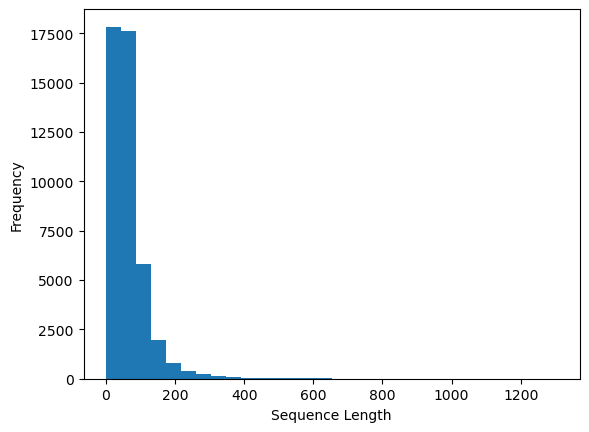

In [49]:
import matplotlib.pyplot as plt #กราฟสำหรับโชว์ว่า ควรตั้ง max สำหรับการ pad เท่าไหร่

# Plot histogram
plt.hist([len(seq) for seq in X_tokenized], bins=30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [28]:
X_train_embed, X_test_embed, y_train_embed, y_test_embed = train_test_split(X_padded, y, test_size=0.3, random_state=42) #แบ่งเป็น 70/30

In [52]:
print(X_train_embed.shape)

(31500, 150)


In [59]:
# ถ้าเคย train model ด้วย model.fit แล้วต้องการรันใหม่อีกครั้งให้เคลียร์ค่า weight เก่าก่อน 
# ถ้าไม่เคลียร์ค่า weight เก่า จะทำการ train ต่อจากครั้งล่าสุด

from keras.backend import clear_session
clear_session()

In [60]:
from keras.layers import Embedding, Flatten, Dense , Dropout
from keras.models import Sequential

model1 = Sequential()
model1.add(Embedding(input_dim=300, output_dim=30, input_length=150)) # embeddings layers 
model1.add(Dropout(0.5)) # dropout regularization
model1.add(Flatten()) # flaternlayers 
model1.add(Dense(units=5, activation='relu'))   
model1.add(Dense(units=3, activation='softmax')) #output layers

ในการสร้าง DNN model ด้วยการใช้ embedding layer และ flattern layer องค์ประกอบต่างๆของmodel จะประกอบไปด้วย

layer1
เป็น embedding layer ที่จะมี input อยู่ที่ 300 (อิงตามจำนวน word) output ที่30 และ input_length ที่ 150 (อิงตามการ padding)

dropout
เป็น regularization เพื่อลด overfit โดยตั้ง droprate ที่ 50%

flattern layer 
ทำหน้าที่เปลี่ยน embeding layer ให้เป็น fullyconnected layer โดยเปลี่ยนจาก arrays 2d เป็น 1d

relu layer
มีหน้าที่ทำให้ model เรียนรู้ที่จะเจอข้อมูลที่ไม่ค่อยมีความสัมพันธ์กันมากนัก และเรียนรู้pattern ยากๆบางตัวภายในdataset ได้

output layers 
เป็น output ที่ตั้งตามจำนวนclass และใช้ softmax สำหรับการกระจายความน่าจะเป็นของข้อมูลออกตอน predict โดยตั้ง units 3 ตามจำนวน target class



In [61]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

loss = sparse_categorical_crossentropy = เอาไว้ใช้กับกรณี muticlassification (dataset ตัวนี้มี target 3 ตัว) ที่จะคำนวณค่าต่างๆออกมาเป็น ความน่าจะเป็นต่างๆแล้วนำไปเปรียบเทียบกับ กับค่าที่เป็น true

metric = accuracy = เป็นคะแนนที่เอาไว้บอกว่า model มีความสามารถในการ predict ออกมาได้ตรงมากขนาดไหน

adam = ใส่ไว้เป็นตัวลด loss เวลาที่ model กำลัง train อยู่

In [62]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 30)           9000      
                                                                 
 dropout (Dropout)           (None, 150, 30)           0         
                                                                 
 flatten (Flatten)           (None, 4500)              0         
                                                                 
 dense (Dense)               (None, 5)                 22505     
                                                                 
 dense_1 (Dense)             (None, 3)                 18        
                                                                 
Total params: 31523 (123.14 KB)
Trainable params: 31523 (123.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


โดย shape ของ X_train_embed เราจะ เป็น (31500,150)

embedding layer
คำนวณได้จาก input*output  = 300*30 = 9000 parameter (รวม weigth และ bias ทั้งหมดแล้ว)

dropout layer
ไม่มี การเพิ่มใดๆ เพียงแค่เป็นการลด overfit เท่านั้น

flattern 
ไม่มีการเพิ่มใดๆ เป็นการreshape embedding layer โดยจะออกoutput จากการคำนวณ sequence length* output = 150 * 30 = 4500 

dense_4 ReLu
คำนวณได้จาก input*units+units = 4500*5+5 = 22505 parameters 

output layers
คำนวณได้จาก input*units+units = 5*3+3 =18

รวม parameter ทั้งหมดจะได้ 9000+0+0+22505+18 = 31523


### รูปภาพ สถาปัตยกรรมของ model ตัวนี้


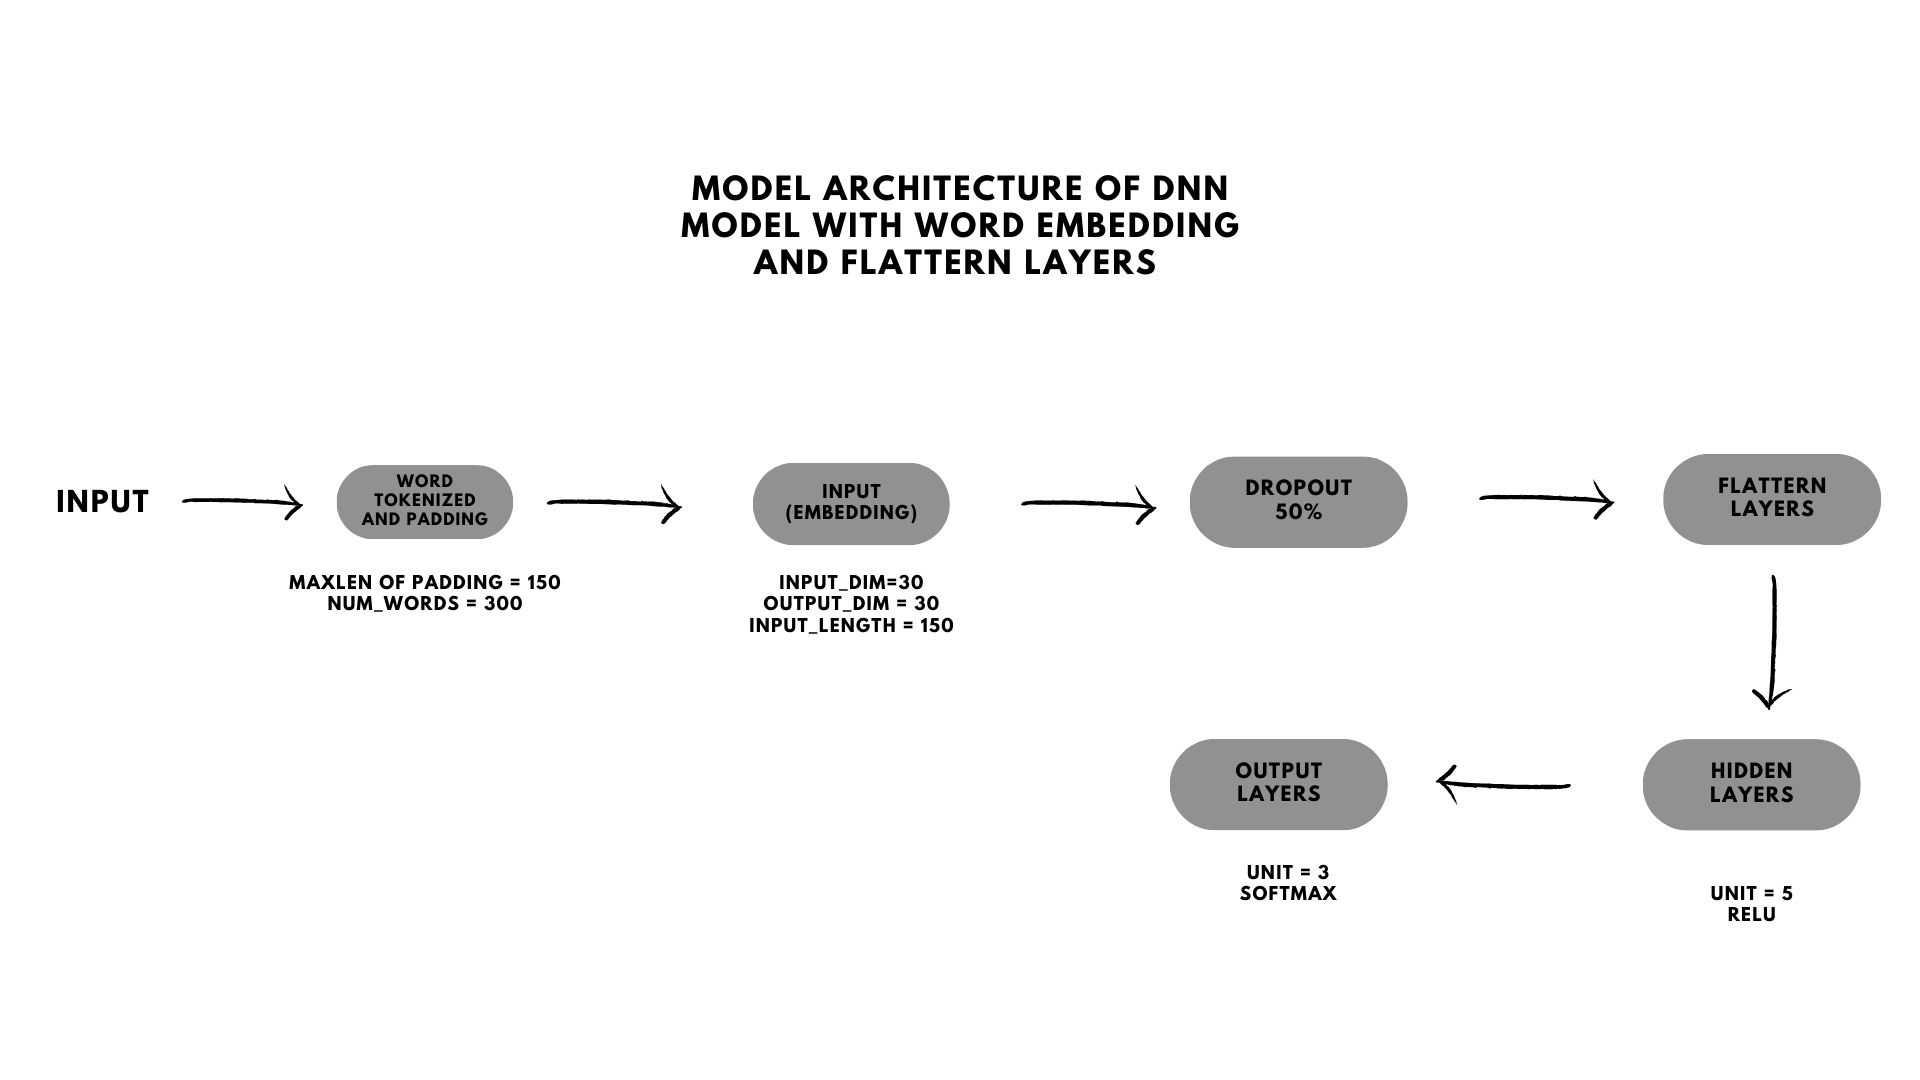

In [2]:
#fuction สำหรับการ insert รูปภาพลง jupyter notebook
import base64
from IPython.display import HTML

image_path = 'flattern_arthi.jpg'

with open(image_path, 'rb') as f:
    image_data = base64.b64encode(f.read()).decode('utf-8')

html_code = f'<img src="data:image/jpeg;base64,{image_data}" width="600" height="350">'
HTML(html_code)

In [63]:
from keras.callbacks import EarlyStopping

# Early stopping เพื่อลด overfit ในกรณีloss เด้งขึ้นมา และจะตัดรอบ กรณีถ้าไม่ดีขค้นภายใน15รอบ
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) 

In [64]:
flat_pad = model1.fit(
    X_train_embed, y_train_embed,
    epochs=50, # ทำ50รอบ
    batch_size=10, # สามารถลดได้ ถ้าอยาก generalize ข้อมูลและขึ้นอยู่กับเครื่อง
    validation_data=(X_test_embed, y_test_embed),
    callbacks=[early_stopping]
)

Epoch 1/50
3150/3150 [==============================] - 7s 2ms/step - loss: 0.5005 - accuracy: 0.7632 - val_loss: 0.3822 - val_accuracy: 0.8249
Epoch 2/50
3150/3150 [==============================] - 6s 2ms/step - loss: 0.3928 - accuracy: 0.8231 - val_loss: 0.3800 - val_accuracy: 0.8287
Epoch 3/50
3150/3150 [==============================] - 5s 2ms/step - loss: 0.3735 - accuracy: 0.8326 - val_loss: 0.3739 - val_accuracy: 0.8321
Epoch 4/50
3150/3150 [==============================] - 5s 2ms/step - loss: 0.3610 - accuracy: 0.8370 - val_loss: 0.3728 - val_accuracy: 0.8331
Epoch 5/50
3150/3150 [==============================] - 5s 2ms/step - loss: 0.3525 - accuracy: 0.8429 - val_loss: 0.3736 - val_accuracy: 0.8287
Epoch 6/50
3150/3150 [==============================] - 5s 2ms/step - loss: 0.3430 - accuracy: 0.8452 - val_loss: 0.3825 - val_accuracy: 0.8276
Epoch 7/50
3150/3150 [==============================] - 6s 2ms/step - loss: 0.3401 - accuracy: 0.8455 - val_loss: 0.3743 - val_accuracy:

In [65]:
loss, accuracy = model1.evaluate(X_train_embed, y_train_embed, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test_embed, y_test_embed, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.8716
Testing Accuracy: 0.8331


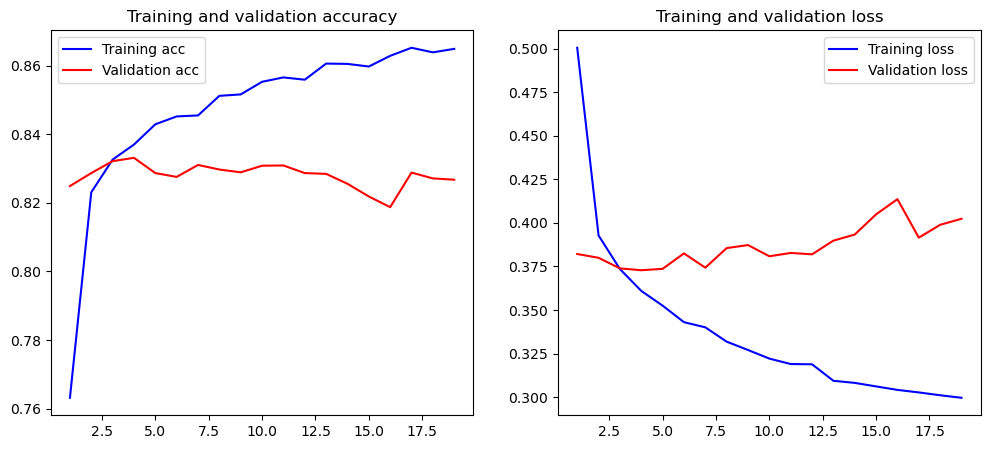

In [66]:
plot_history(flat_pad) #plot ออกมาเพื่อดูว่า model เป็นยังไง

### สรุป

จากการใช้ word embedding และ flattern layer ร่วมกับการ ลองผิดลองถูกในตัว parameter ต่างๆให้เหมาะกับmodel จะพบว่าดีกว่า model ก่อนหน้า ที่ใช้แค่countvectorizer อย่างเดียวอย่างมาก เพราะโอกาสเกิดoverfit ของข้อมูลนั้นลดต่ำลง แต่ยังมีแนวโน้มจะเพิ่มขึ้นถ้าหากยังทำหลายๆ อีกepoch จึงต้อง implement early stop เข้าไปหยุดไว้ก่อน


### เทียบคะแนนกับ model ตัวอื่นๆ 

DNN with CountVectorizer (ตัวที่แย่ที่สุด)

Train Accuracy : 0.925
Validation Accuracy : 0.875


DNN with Flattern layers and word embeddings (ตัวที่ดีที่สุด อันดับ2)

Training Accuracy: 0.8716
Validation Accuracy: 0.8331


DNN with GlobalMaxpooling layer and word embeddings (ตัวที่ดีที่สุด)

Training Accuracy: 0.8722
Validation Accuracy: 0.8620


DNN with ConVU1d and word embeddings (อันดับ3)

Training Accuracy: 0.8692
Validation Accuracy: 0.8453